In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, norm
from scipy import stats
import math

# load data frame
df = pd.read_csv('masterschool_ab_test_query_results.csv')

display(df)


,uid,group,join_dt,device,id,country,gender,uid.1,dt,device.1,spent
0,1000000,B,2023-01-28,I,1000000,CAN,M,NaN,NaN,NaN,NaN
1,1000001,A,2023-01-27,A,1000001,BRA,M,NaN,NaN,NaN,NaN
2,1000002,A,2023-02-01,A,1000002,FRA,M,NaN,NaN,NaN,NaN
3,1000003,B,2023-01-25,I,1000003,BRA,M,NaN,NaN,NaN,NaN
4,1000004,A,2023-02-04,A,1000004,DEU,F,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
49077,1049995,B,2023-02-03,A,1049995,BRA,F,NaN,NaN,NaN,NaN
49078,1049996,A,2023-01-29,A,1049996,USA,F,NaN,NaN,NaN,NaN
49079,1049997,B,2023-02-03,A,1049997,BRA,M,NaN,NaN,NaN,NaN
49080,1049998,B,2023-02-03,I,1049998,CAN,M,NaN,NaN,NaN,NaN


Data cleaning
1. apply NaN as 0
2. Check if uid is unique
3. remove nan value in device


In [2]:
# calculate nan values in each column
df.isna().sum()

uid             0
group           0
join_dt         0
device        295
id              0
country       647
gender       6882
uid.1       46849
dt          46849
device.1    46859
spent       46849
dtype: int64

There are several columns that have missing values (uid.1, dt, device.1, and spent). The column spent is of interest for our analysis, so filling missing values in 'spent' with zero can be done here. 

In [12]:
# Handling missing values in 'spent' by filling them with zero.
df['spent'] = df['spent'].fillna(0)

# Check the df after operationb
print(df)

           uid group     join_dt device       id country gender  uid.1   dt   
0      1000000     B  2023-01-28      I  1000000     CAN      M    NaN  NaN  \
1      1000001     A  2023-01-27      A  1000001     BRA      M    NaN  NaN   
2      1000002     A  2023-02-01      A  1000002     FRA      M    NaN  NaN   
3      1000003     B  2023-01-25      I  1000003     BRA      M    NaN  NaN   
4      1000004     A  2023-02-04      A  1000004     DEU      F    NaN  NaN   
...        ...   ...         ...    ...      ...     ...    ...    ...  ...   
49077  1049995     B  2023-02-03      A  1049995     BRA      F    NaN  NaN   
49078  1049996     A  2023-01-29      A  1049996     USA      F    NaN  NaN   
49079  1049997     B  2023-02-03      A  1049997     BRA      M    NaN  NaN   
49080  1049998     B  2023-02-03      I  1049998     CAN      M    NaN  NaN   
49081  1049999     B  2023-01-29      I  1049999     GBR      M    NaN  NaN   

      device.1  spent  
0          NaN    0.0  
1  

It'll be helpful to see the overview for each treatment group and control group so performing the calculation to know how many percentage each group has will be useful for the analysis then plot them to aim better visualisation. It's also helpful to perform descriptive analysis.

In [13]:
# Count percentage of each group: A Control and B Treatment
print(df["group"].value_counts() / df["group"].count()*100)

group
B    50.2832
A    49.7168
Name: count, dtype: float64


In [14]:

# Perform descriptive analysis
df.describe()


,uid,id,uid.1,spent
count,4.908200e+04,4.908200e+04,2.233000e+03,49082.000000
mean,1.025002e+06,1.025002e+06,1.024961e+06,3.373156
std,1.443515e+04,1.443515e+04,1.429434e+04,25.079623
min,1.000000e+06,1.000000e+06,1.000039e+06,0.000000
25%,1.012508e+06,1.012508e+06,1.012788e+06,0.000000
50%,1.024994e+06,1.024994e+06,1.024733e+06,0.000000
75%,1.037505e+06,1.037505e+06,1.037457e+06,0.000000
max,1.049999e+06,1.049999e+06,1.049973e+06,1659.400000


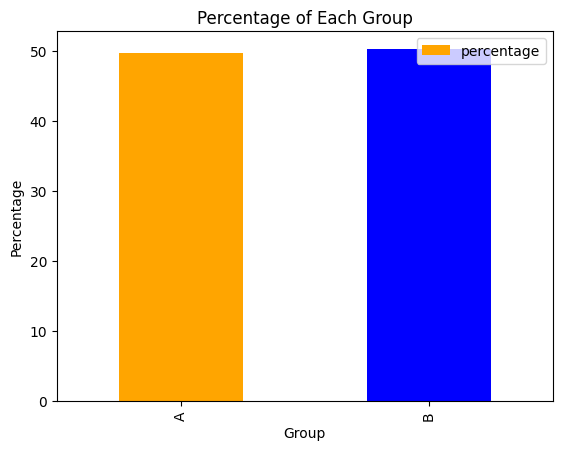

In [15]:
# Sample data
data = {
    "group": ["A", "B"],
    "percentage": [49.7168, 50.2832]
}

df_1 = pd.DataFrame(data)

# Create a mapping of colors for each group
color_map = {"A": "blue", "B": "orange"}

# Plot the bar chart
ax = df_1.plot(kind="bar", x="group", y="percentage", color=[color_map[group] for group in df["group"]])

# Reverse the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))

# Set the labels and title
ax.set_xlabel("Group")
ax.set_ylabel("Percentage")
ax.set_title("Percentage of Each Group")

# Show the plot
plt.show()


As for the device, country, and gender columns, these also have missing values, but they are not directly related to the calculations. Therefore these will be exluded at this moment.

### Metric of interest

In this case, the metrics are the average amount spent per user and the user conversion rate. 

In [16]:
# classify users in each group
group_A = df[df['group'] == 'A'][['uid', 'group', 'join_dt', 'spent']]
group_B = df[df['group'] == 'B'][['uid', 'group', 'join_dt', 'spent']]

# Calculate average spending for each group
average_A = group_A['spent'].mean()
average_B = group_B['spent'].mean()

print(f'Average spending for Group A: {average_A: .2f}')
print(f'Average spending for Group B: {average_B: .2f}')

Average spending for Group A:  3.37
Average spending for Group B:  3.38


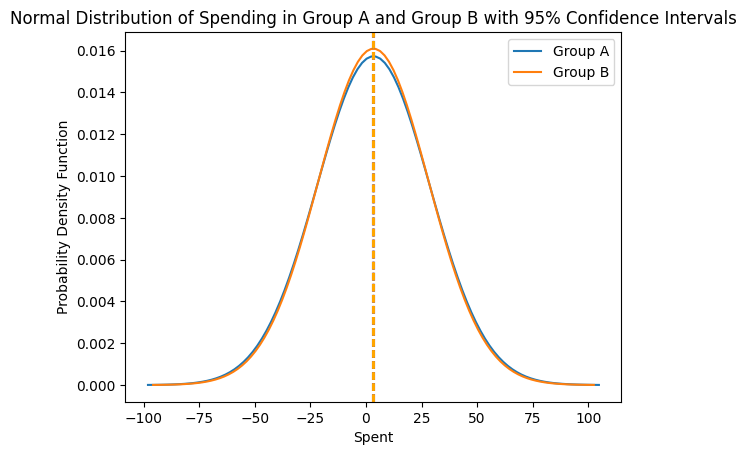

((3.0480779210118714, 3.684640959800503),
 (3.0705549442047295, 3.6891960176097176))

In [17]:
# Define the groups
group_A = df[df['group'] == 'A']['spent']
group_B = df[df['group'] == 'B']['spent']

# Calculate the mean spending for each group
mean_A = group_A.mean()
mean_B = group_B.mean()

# Calculate the number of observations in each group
n_A = len(group_A)
n_B = len(group_B)

# Calculate the standard deviation of spending in each group
std_dev_A = group_A.std(ddof=1)
std_dev_B = group_B.std(ddof=1)

# Calculate the standard error of the mean for each group
sem_A = std_dev_A / np.sqrt(n_A)
sem_B = std_dev_B / np.sqrt(n_B)

# Calculate the 95% confidence interval for the mean spending in each group
confidence_interval_A = (mean_A - 1.96*sem_A, mean_A + 1.96*sem_A)
confidence_interval_B = (mean_B - 1.96*sem_B, mean_B + 1.96*sem_B)

# Plot the normal distribution for each group
x = np.linspace(mean_A - 4*std_dev_A, mean_A + 4*std_dev_A, 100)
plt.plot(x, norm.pdf(x, mean_A, std_dev_A), label='Group A')

x = np.linspace(mean_B - 4*std_dev_B, mean_B + 4*std_dev_B, 100)
plt.plot(x, norm.pdf(x, mean_B, std_dev_B), label='Group B')

# Plot the confidence intervals
plt.axvline(confidence_interval_A[0], color='blue', linestyle='dashed')
plt.axvline(confidence_interval_A[1], color='blue', linestyle='dashed')
plt.axvline(confidence_interval_B[0], color='orange', linestyle='dashed')
plt.axvline(confidence_interval_B[1], color='orange', linestyle='dashed')

plt.legend()
plt.xlabel('Spent')
plt.ylabel('Probability Density Function')
plt.title('Normal Distribution of Spending in Group A and Group B with 95% Confidence Intervals')

plt.show()

confidence_interval_A, confidence_interval_B

In [18]:
# Identify users in each group who made a purchase
converted_users_A = group_A[group_A['spent'] > 0]['uid'].unique()
converted_users_B = group_B[group_B['spent'] > 0]['uid'].unique()

# Count the number of unique converters in each group
conversions_A = len(converted_users_A)
conversions_B = len(converted_users_B)

# Count the total number of unique users in each group
total_users_A = group_A['uid'].nunique()
total_users_B = group_B['uid'].nunique()

# Calculate conversion rates
conversion_rate_A = conversions_A / total_users_A
conversion_rate_B = conversions_B / total_users_B

print(f'Conversion rate for Group A: {conversion_rate_A * 100:.2f}%')
print(f'Conversion rate for Group B: {conversion_rate_B * 100:.2f}%')


KeyError: 'spent'

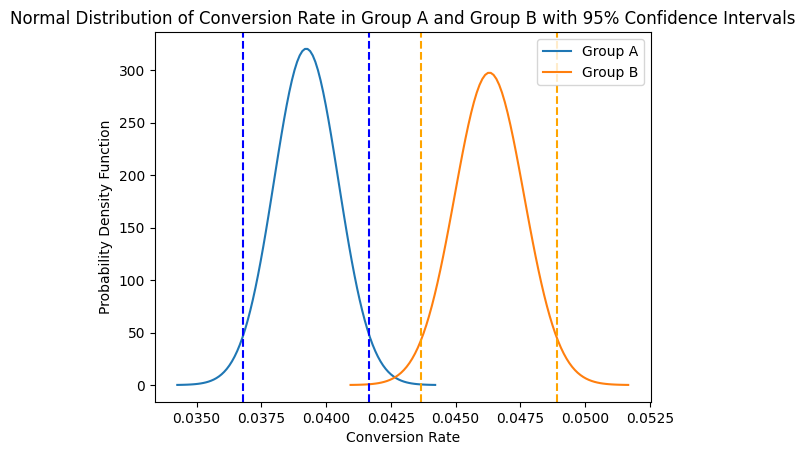

((0.03679209516027415, 0.0416698856966457),
 (0.04367485043175266, 0.048926775584507504))

In [19]:
# Define the groups
group_A = df[df['group'] == 'A']
group_B = df[df['group'] == 'B']

# Identify users in each group who made a purchase
converted_users_A = group_A[group_A['spent'] > 0]['uid'].unique()
converted_users_B = group_B[group_B['spent'] > 0]['uid'].unique()

# Count the number of unique converters in each group
conversions_A = len(converted_users_A)
conversions_B = len(converted_users_B)

# Count the total number of unique users in each group
total_users_A = group_A['uid'].nunique()
total_users_B = group_B['uid'].nunique()

# Calculate conversion rates
conversion_rate_A = conversions_A / total_users_A
conversion_rate_B = conversions_B / total_users_B

# Calculate the standard error for the conversion rate in each group
se_conversion_A = np.sqrt((conversion_rate_A * (1 - conversion_rate_A)) / total_users_A)
se_conversion_B = np.sqrt((conversion_rate_B * (1 - conversion_rate_B)) / total_users_B)

# Calculate the 95% confidence interval for the conversion rate in each group
confidence_interval_conversion_A = (conversion_rate_A - 1.96*se_conversion_A, conversion_rate_A + 1.96*se_conversion_A)
confidence_interval_conversion_B = (conversion_rate_B - 1.96*se_conversion_B, conversion_rate_B + 1.96*se_conversion_B)

# Plot the normal distribution for each group's conversion rate
x = np.linspace(conversion_rate_A - 4*se_conversion_A, conversion_rate_A + 4*se_conversion_A, 100)
plt.plot(x, norm.pdf(x, conversion_rate_A, se_conversion_A), label='Group A')

x = np.linspace(conversion_rate_B - 4*se_conversion_B, conversion_rate_B + 4*se_conversion_B, 100)
plt.plot(x, norm.pdf(x, conversion_rate_B, se_conversion_B), label='Group B')

# Plot the confidence intervals
plt.axvline(confidence_interval_conversion_A[0], color='blue', linestyle='dashed')
plt.axvline(confidence_interval_conversion_A[1], color='blue', linestyle='dashed')
plt.axvline(confidence_interval_conversion_B[0], color='orange', linestyle='dashed')
plt.axvline(confidence_interval_conversion_B[1], color='orange', linestyle='dashed')

plt.legend()
plt.xlabel('Conversion Rate')
plt.ylabel('Probability Density Function')
plt.title('Normal Distribution of Conversion Rate in Group A and Group B with 95% Confidence Intervals')

plt.show()

confidence_interval_conversion_A, confidence_interval_conversion_B


Calculating the 95% confidence interval for the conversion rate of group A involves estimating the range in which we can be 95% confident the true population conversion rate lies; using one-stample z-interval.

Since we're dealing with proportions (conversion rates), we can use the following formula to calculate the confidence interval:

CI = $\hat{p} \pm z \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$

where:

 $ \hat{p} $ is the sample proportion (equivalent to conversion rate) <br>
z is the z-score corresponding to the desired level of confidence (1.96 for a 95% confidence interval), <br>
n is the sample size.


One-sample: This indicates that the confidence interval is being constructed based on data from a single sample. In contrast, a two-sample interval would be used if we were comparing two different groups or samples (for example, comparing the mean of group A with the mean of group B).

Z-interval: This indicates that the method for constructing the confidence interval is based on the standard normal distribution (Z-distribution). This is typically used when the population standard deviation is known, or when the sample size is sufficiently large (greater than 30 is a common rule of thumb) such that the sample standard deviation can be used as a reliable estimate of the population standard deviation.

In the context of calculating a confidence interval for a conversion rate (which is a type of proportion), a one-sample z-interval would be appropriate because you're estimating a parameter based on a single sample (the group of users who could convert), and the calculation is based on the assumption that the sampling distribution of the proportion is approximately normally distributed (thanks to the Central Limit Theorem), which allows the use of the Z-distribution.

In [20]:
from scipy.stats import norm

# Calculate observed conversion rate
conversion_rate_A

# Calculate z-score for 95% confidence level
z = norm.ppf(0.975)

# Calculate standard error
std_err_A = math.sqrt((conversion_rate_A * (1 - conversion_rate_A)) / n_A)

# Calculate confidence interval
conf_interval_A = (conversion_rate_A - z * std_err_A, conversion_rate_A + z * std_err_A)

print(f'95% Confidence interval for the conversion rate of users in Group A: {conf_interval_A}')

95% Confidence interval for the conversion rate of users in Group A: (0.036795090128380815, 0.04166689072853904)


Now the same calculation is executed to look for 95% Confidence Interval for the conversion rate of users in Group B:


In [21]:
# Calculate observed conversion rate
conversion_rate_A

# Calculate z-score for 95% confidence level
z = norm.ppf(0.975)

# Calculate standard error
std_err_B = math.sqrt((conversion_rate_B * (1 - conversion_rate_B)) / n_B)

# Calculate confidence interval
conf_interval_B = (conversion_rate_B - z * std_err_B, conversion_rate_B + z * std_err_B)

print(f'95% Confidence interval for the conversion rate of users in Group A: {conf_interval_B}')

95% Confidence interval for the conversion rate of users in Group A: (0.043679158077865696, 0.04892246793839447)


## Hypothesis Testing

### Hypothesis test in average amount of spent

To determine if there is a significant difference in the average amount spent per user between the two groups,  a two-sample independent t-test is conducted. This statistical hypothesis test compares the means of two independent groups to see if they are significantly different.

two hypotheses for this test:

Null Hypothesis (H0): There is no difference in the average amount spent between Group A and Group B.
Alternative Hypothesis (H1): There is a difference in the average amount spent between Group A and Group B.

In [22]:
# Conduct t-test
t_stat, p_val = stats.ttest_ind(group_A['spent'], group_B['spent'])

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")

t-statistic: -0.0596964133699201
p-value: 0.9523976714075935


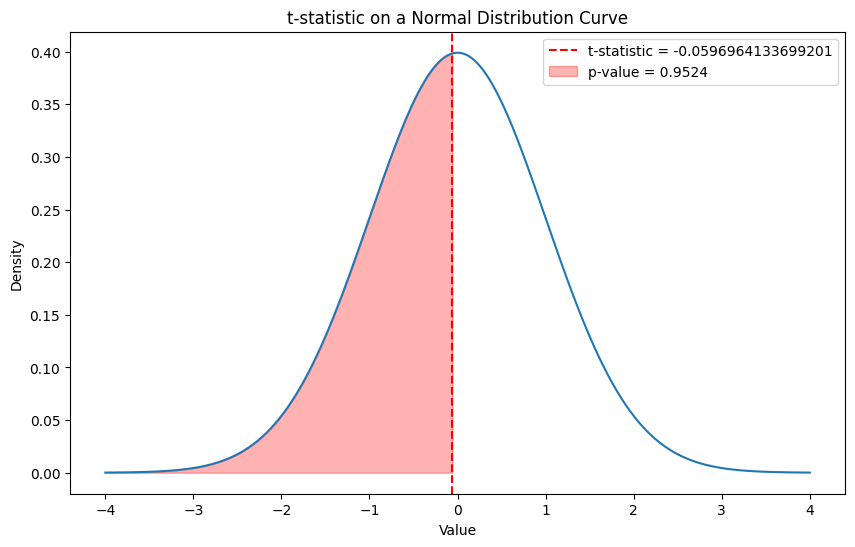

In [23]:

# Create a range of x values
x = np.linspace(-4, 4, 1000)

# Create a standard normal distribution
y = stats.norm.pdf(x, 0, 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y)

# Add a vertical line for the t-statistic
plt.axvline(t_stat, color='red', linestyle='--', label=f't-statistic = {t_stat}')

# Add shading for the p-value
# Since the p-value is two-tailed, we divide it by 2
x_fill_left = np.linspace(-4, t_stat, 1000)
y_fill_left = stats.norm.pdf(x_fill_left, 0, 1)
plt.fill_between(x_fill_left, 0, y_fill_left, color='red', alpha=0.3, label=f'p-value = {p_val :.4f}')


# Add labels and legend
plt.title('t-statistic on a Normal Distribution Curve')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.show()

In [24]:
# Determine if we reject or fail to reject the null hypothesis
if p_val < 0.05:  # Using common statistical significance level of 0.05
    print("We reject the null hypothesis and conclude there is a significant difference in average spending between Group A and Group B.")
else:
    print("statistically insignificant. We fail to reject the null hypothesis that there is no difference in the mean amount spent per user between the control and treatment.")

statistically insignificant. We fail to reject the null hypothesis that there is no difference in the mean amount spent per user between the control and treatment.


### Hypothesis test conversion rates

And now the hypothesis test to see whether there is a difference in the conversion rate between the two groups is conducted.
This test uses the normal distribution and a 5% significance level and the pooled proportion for the standard error.

In [25]:
# Calculate observed conversion rates
p_A = conversions_A / total_users_A
p_B = conversions_B / total_users_B

# Calculate pooled proportion
pooled_p = (conversions_A + conversions_B) / (total_users_A + total_users_B)
print("pool p: " + str(pooled_p))

# Calculate standard error using the pooled proportion
std_err_pooled = math.sqrt(pooled_p * (1 - pooled_p) * (1/total_users_A + 1/total_users_B))
print("standar err pooled: " + str(std_err_pooled))

# Calculate z-score
z_score = (p_A - p_B) / std_err_pooled
print("z_score : " + str(z_score))
# Calculate p-value
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  

# Output p-value and conclusion
print(f'p-value: {p_value}')
if p_value < 0.05:  # Using a 5% significance level
    print('We reject the null hypothesis and conclude there is a significant difference in conversion rates between the two groups.')
else:
    print('We fail to reject the null hypothesis and conclude there is no significant difference in conversion rates between the two groups.')

pool p: 0.04278446355965102
standar err pooled: 0.001829526081285274
z_score : -3.864291770414927
p-value: 0.00011141198532937935
We reject the null hypothesis and conclude there is a significant difference in conversion rates between the two groups.


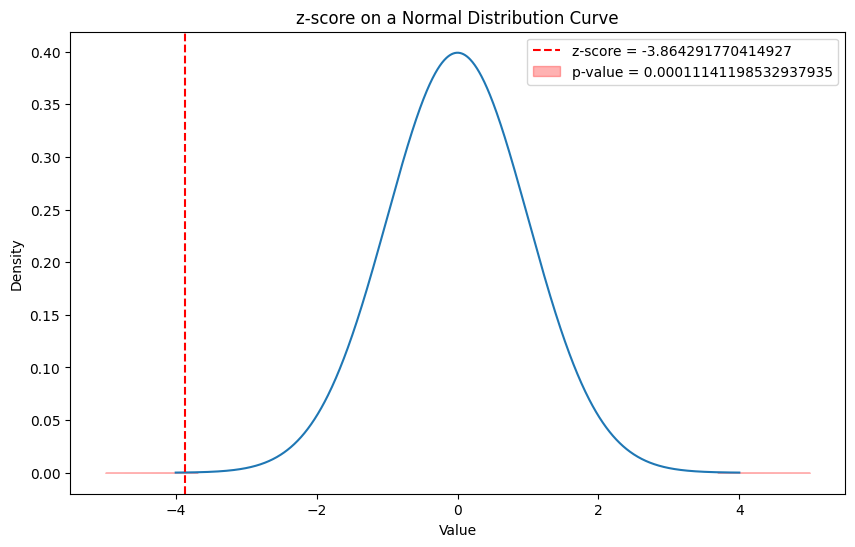

In [26]:
# Create a range of x values
x = np.linspace(-4, 4, 1000)

# Create a standard normal distribution
y = stats.norm.pdf(x, 0, 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y)

# Add a vertical line for the z-score
plt.axvline(z_score, color='red', linestyle='--', label=f'z-score = {z_score}')

# Add shading for the p-value
critical_z_right = norm.ppf(1 - p_value)
critical_z_left = norm.ppf(p_value)

x_fill_right = np.linspace(critical_z_right, 5, 100)
y_fill_right = norm.pdf(x_fill_right, 0, 1)

x_fill_left = np.linspace(-5, critical_z_left, 100)
y_fill_left = norm.pdf(x_fill_left, 0, 1)

plt.fill_between(x_fill_right, 0, y_fill_right, color='red', alpha=0.3)
plt.fill_between(x_fill_left, 0, y_fill_left, color='red', alpha=0.3, label=f'p-value = {p_value}')

# Add labels and legend
plt.title('z-score on a Normal Distribution Curve')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

## Confidence Intervals

The two-sample t-interval for a difference in means can be calculated using the formula for the confidence interval:
CI = (M1 - M2) ± t_critical * sqrt[(s1^2/n1) + (s2^2/n2)]

where:

M1 and M2 are the means of the two groups,
s1 and s2 are the standard deviations of the two groups,
n1 and n2 are the sample sizes of the two groups,
t_critical is the critical value from the t-distribution.


In [27]:
# Calculate means
mean_A = group_A['spent'].mean()
mean_B = group_B['spent'].mean()

# Calculate standard deviations
std_dev_A = group_A['spent'].std()
std_dev_B = group_B['spent'].std()

# Calculate sample sizes
n_A = len(group_A)
n_B = len(group_B)

# Calculate the difference in means
mean_diff = mean_B - mean_A

# Calculate the standard error
std_err_diff = np.sqrt((std_dev_A**2/n_A) + (std_dev_B**2/n_B))

# Calculate the degrees of freedom
df = n_A + n_B - 2

# Calculate the critical value (two-tailed test, so alpha is 0.025 at each tail)
t_critical = stats.t.ppf(q = 1-0.025, df = df)

# Calculate the margin of error
margin_of_error = t_critical * std_err_diff

# Calculate the confidence interval
confidence_interval = (mean_diff - margin_of_error, mean_diff + margin_of_error)

print(f'Confidence interval for the difference in means: {confidence_interval}')

Confidence interval for the difference in means: (-0.4303136525914925, 0.4573457335935653)


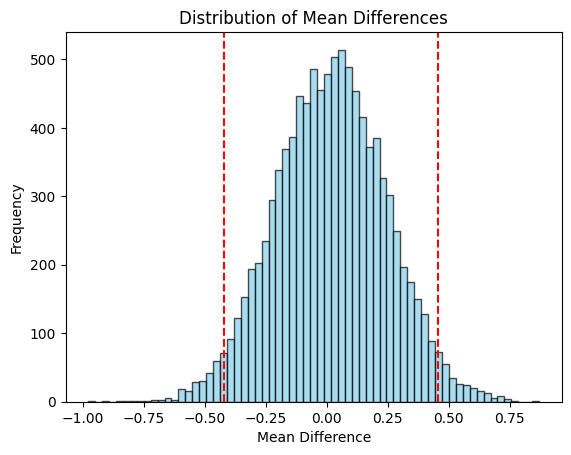

In [28]:
s_group_a = group_A['spent']
s_group_b = group_B['spent']

# Number of bootstrap samples to take
n_bootstrap_samples = 10000

# Array to hold the bootstrap sample mean differences
bootstrap_mean_diffs = np.empty(n_bootstrap_samples)


# Generate the bootstrap samples and calculate the mean differences for each
for i in range(n_bootstrap_samples):
    bootstrap_sample_a = np.random.choice(s_group_a, size=n_A, replace=True)
    bootstrap_sample_b = np.random.choice(s_group_b, size=n_B, replace=True)
    bootstrap_mean_diffs[i] = np.mean(bootstrap_sample_b) - np.mean(bootstrap_sample_a)


# Calculate the 95% confidence interval for the mean difference
conf_int = np.percentile(bootstrap_mean_diffs, [2.5, 97.5])

# Plot the distribution of bootstrap mean differences
plt.hist(bootstrap_mean_diffs, bins='auto', alpha=0.7, color='skyblue', edgecolor='black' )

# Plot the 95% confidence interval
plt.axvline(conf_int[0], color='red', linestyle='dashed')
plt.axvline(conf_int[1], color='red', linestyle='dashed')

plt.title('Distribution of Mean Differences')
plt.xlabel('Mean Difference')
plt.ylabel('Frequency')

plt.show()

The 95% confidence interval for the difference in the conversion rate between the treatment and control (treatment-control) is conducted by using the normal distribution and unpooled proportion for the standard error.

In [29]:
# Calculate conversion rates
p_A = conversions_A / total_users_A
p_B = conversions_B / total_users_B
print(p_A)
print(p_B)

# Calculate standard errors
std_err_A = np.sqrt(p_A * (1 - p_A) / total_users_A)
std_err_B = np.sqrt(p_B * (1 - p_B) / total_users_B)
print(std_err_A)
print(std_err_B)

# Calculate the difference in conversion rates and the standard error of the difference
conversion_rate_diff = p_B - p_A
std_err_diff = np.sqrt(std_err_A**2 + std_err_B**2)
print(conversion_rate_diff)
print(std_err_diff)

# Calculate z-score for a 95% confidence interval
z_score = norm.ppf(0.975)
print(z_score)

# Calculate the margin of error
margin_of_error = z_score * std_err_diff
print(margin_of_error) 

# Calculate the confidence interval
conf_interval = (conversion_rate_diff - margin_of_error, conversion_rate_diff + margin_of_error)

print(f'95% Confidence interval for the difference in conversion rates: {conf_interval}')


0.03923099042845993
0.04630081300813008
0.001244334320502947
0.0013397768246823593
0.0070698225796701555
0.0018284884033368863
1.959963984540054
0.003583771416689445
95% Confidence interval for the difference in conversion rates: (0.0034860511629807105, 0.0106535939963596)


95% Confidence interval for the difference in conversion rates: (0.0034860511629807105, 0.0106535939963596)


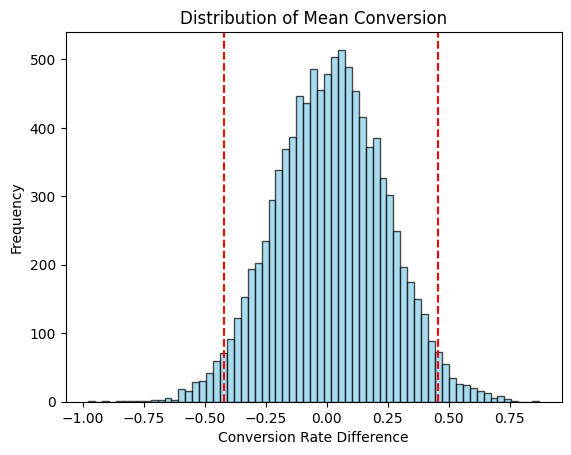

In [30]:
# Calculate conversion rates for each group
group_A['converted'] = group_A['spent'].apply(lambda x: 1 if x > 0 else 0)
group_B['converted'] = group_B['spent'].apply(lambda x: 1 if x > 0 else 0)

# Number of bootstrap samples to take
n_bootstrap_samples = 10000

# Array to hold the bootstrap sample conversion rate differences
bootstrap_conversion_rate_diffs = np.empty(n_bootstrap_samples)

# Generate the bootstrap samples and calculate the conversion rate difference for each
for i in range(n_bootstrap_samples):
    bootstrap_sample_A = np.random.choice(group_A['converted'], size=len(group_A), replace=True)
    bootstrap_sample_B = np.random.choice(group_B['converted'], size=len(group_B), replace=True)
    bootstrap_conversion_rate_diffs[i] = bootstrap_sample_B.mean() - bootstrap_sample_A.mean()

# Calculate the 95% confidence interval for the conversion rate difference

# Print the confidence interval
print(f"95% Confidence interval for the difference in conversion rates: {conf_interval}")

# Plot the distribution of bootstrap mean differences
plt.hist(bootstrap_mean_diffs, bins='auto', alpha=0.7, color='skyblue', edgecolor='black' )

# Plot the 95% confidence interval
plt.axvline(conf_int[0], color='red', linestyle='dashed')
plt.axvline(conf_int[1], color='red', linestyle='dashed')

plt.title('Distribution of Mean Conversion')
plt.xlabel('Conversion Rate Difference')
plt.ylabel('Frequency')

plt.show()


## Conclusion

While the new experience (treatment) does not significantly increase the average amount spent per user, it does significantly increase the user conversion rate. This suggests that while individual users may not be spending more, more users are choosing to spend. This could result in increased total revenue, especially if scaled to a large user base.

Therefore, the recommendation would be to launch the new experience to all users. However, it would be beneficial to continuously monitor user behavior and feedback to ensure the new experience continues to positively impact user conversion rates without negatively impacting other important metrics.